In [32]:
from msmbuilder.example_datasets import FsPeptide
from msmbuilder.featurizer import DihedralFeaturizer

fs = FsPeptide().get().trajectories
n_atoms = fs[0].n_atoms
dih_model = DihedralFeaturizer(['phi', 'psi', 'omega', 'chi1', 'chi2', 'chi3', 'chi4'])
fs_dih_feat = dih_model.transform(fs)

import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
%matplotlib inline

loading trajectory_1.xtc...
loading trajectory_10.xtc...
loading trajectory_11.xtc...
loading trajectory_12.xtc...
loading trajectory_13.xtc...
loading trajectory_14.xtc...
loading trajectory_15.xtc...
loading trajectory_16.xtc...
loading trajectory_17.xtc...
loading trajectory_18.xtc...
loading trajectory_19.xtc...
loading trajectory_2.xtc...
loading trajectory_20.xtc...
loading trajectory_21.xtc...
loading trajectory_22.xtc...
loading trajectory_23.xtc...
loading trajectory_24.xtc...
loading trajectory_25.xtc...
loading trajectory_26.xtc...
loading trajectory_27.xtc...
loading trajectory_28.xtc...
loading trajectory_3.xtc...
loading trajectory_4.xtc...
loading trajectory_5.xtc...
loading trajectory_6.xtc...
loading trajectory_7.xtc...
loading trajectory_8.xtc...
loading trajectory_9.xtc...


In [33]:
len(['phi', 'psi', 'omega', 'chi1', 'chi2', 'chi3', 'chi4'])

7

In [34]:
7*23

161

In [35]:
from msmbuilder.decomposition import tICA
tica = tICA(lag_time=100)
tica.fit(fs_dih_feat)

tICA(gamma=0.05, lag_time=100, n_components=148, weighted_transform=False)

In [36]:
X = tica.transform(fs_dih_feat)

In [37]:
X_ = np.vstack(X)

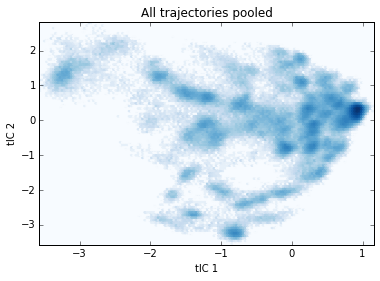

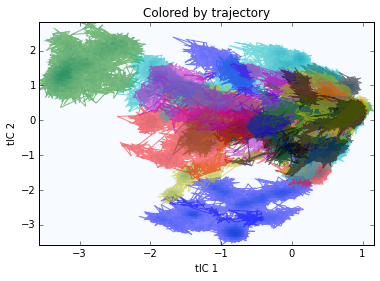

In [39]:
plt.hexbin(X_[:,0],X_[:,1],bins='log',gridsize=150,cmap='Blues')
plt.xlabel('tIC 1')
plt.ylabel('tIC 2')
plt.title('All trajectories pooled')

plt.figure()

plt.hexbin(X_[:,0],X_[:,1],bins='log',gridsize=150,cmap='Blues')

#colors = plt.cm.rainbow(range(len(X)))

for i,x in enumerate(X):
    plt.plot(x[:,0],x[:,1],alpha=0.5,linewidth=1,linestyle='-')#,c=colors[i])
plt.xlabel('tIC 1')
plt.ylabel('tIC 2')
plt.title('Colored by trajectory')

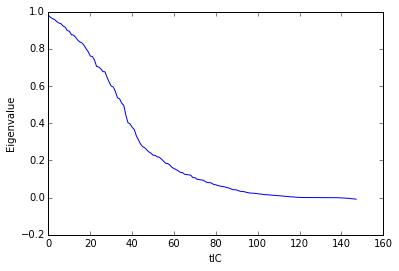

In [8]:
plt.plot(tica.eigenvalues_)
plt.xlabel('tIC')
plt.ylabel('Eigenvalue')

In [9]:
# how to measure overlap?

# dumb first pass attempt: compute a 2D (or N-D) histogram from each trajectory, using the same set of coordinates
# for each.

# the overlap could then be a function of how many points are in common in each bin between two histograms

In [10]:
ndim=2
lims = zip(X_[:,:ndim].min(0),X_[:,:ndim].max(0))
lims

[(-3.5749559007962604, 1.1589390262008588),
 (-3.5709588743146066, 2.832324696579541)]

In [11]:
hist,xedges,yedges = np.histogram2d(X_[:,0],X_[:,1],range=lims,bins=150)

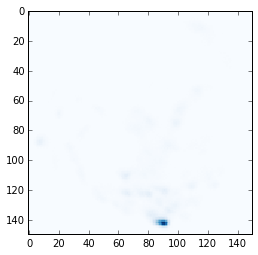

In [12]:
plt.imshow(hist,cmap='Blues',interpolation='none');

In [13]:
histograms = []
for i,x in enumerate(X):
    hist,_,_ = np.histogram2d(x[:,0],x[:,1],range=lims,bins=150)
    histograms.append(hist)

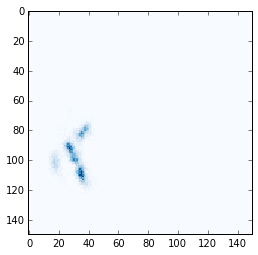

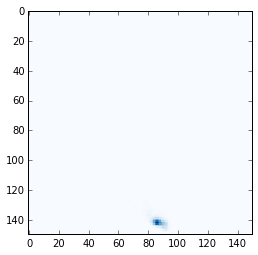

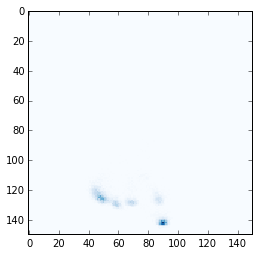

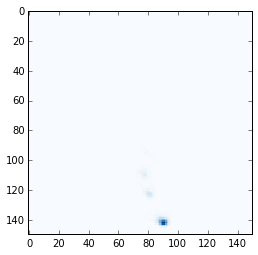

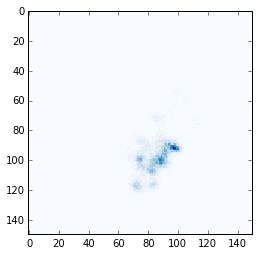

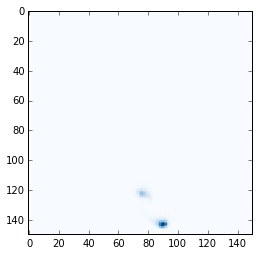

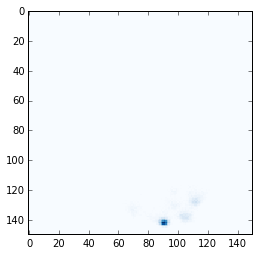

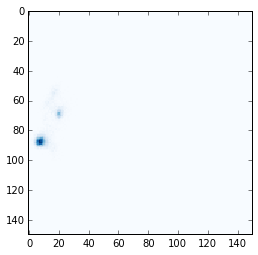

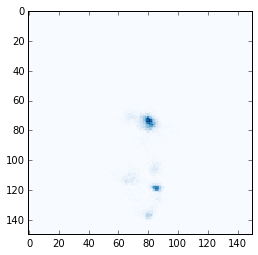

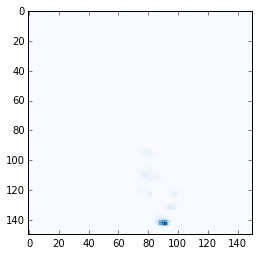

In [14]:
for h in histograms[:10]:
    plt.figure()
    plt.imshow(h,cmap='Blues',interpolation='none');

In [15]:
np.sum(hist*hist) # all entries in hist are >= 0

675776.0

In [16]:
overlap = np.zeros((len(histograms),len(histograms)))
for i,hist_i in enumerate(histograms):
    for j,hist_j in enumerate(histograms):
        if i != j:
            overlap[i,j] = np.sum(np.minimum(hist_i,hist_j))

<matplotlib.colorbar.Colorbar instance at 0x1053e7488>

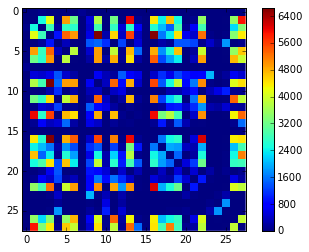

In [17]:
plt.imshow(overlap,interpolation='none');
plt.colorbar()

In [18]:
# which trajectory has the lowest overlap with other trajectories
total_overlap = overlap.sum(0)
np.min(total_overlap),np.argmin(total_overlap)

(13.0, 15)

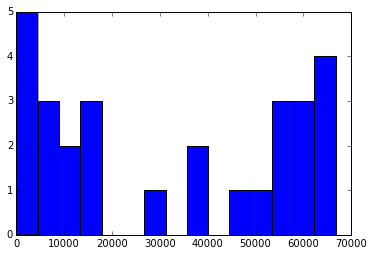

In [19]:
plt.hist(total_overlap,bins=15);

In [20]:
total_overlap_ordering = sorted(range(len(X)),key=lambda i:total_overlap[i])

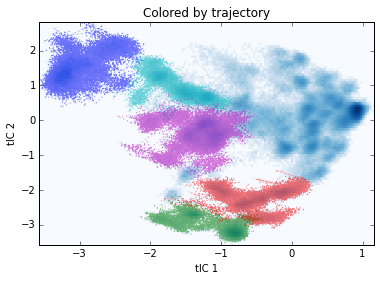

In [21]:
plt.hexbin(X_[:,0],X_[:,1],bins='log',gridsize=150,cmap='Blues')

#colors = plt.cm.rainbow(range(len(X)))

for i in range(5):
    x = X[total_overlap_ordering[i]]
    plt.plot(x[:,0],x[:,1],alpha=0.5,linewidth=1,linestyle=':')#,c=colors[i])
plt.xlabel('tIC 1')
plt.ylabel('tIC 2')
plt.title('Colored by trajectory')

# the five trajectories with lowest overlap

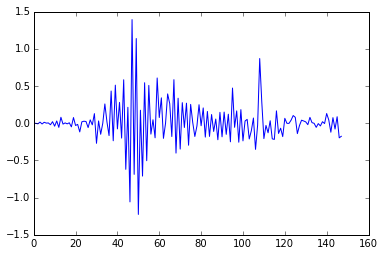

In [22]:
plt.plot(tica.eigenvectors_[0])

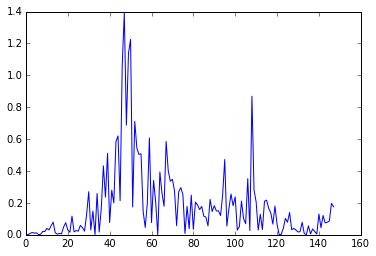

In [23]:
plt.plot(np.abs(tica.eigenvectors_[0]))

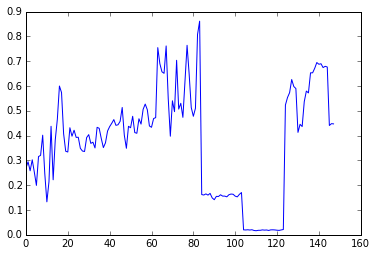

In [24]:
plt.plot(np.vstack(fs_dih_feat).std(0))

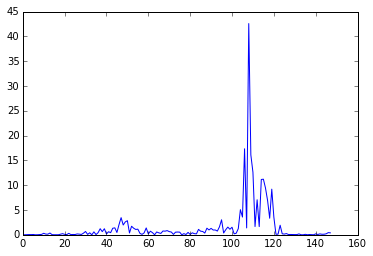

In [25]:
plt.plot(np.abs(tica.eigenvectors_[0])/np.vstack(fs_dih_feat).std(0))

In [26]:
np.argmax(np.abs(tica.eigenvectors_[0])/np.vstack(fs_dih_feat).std(0))

108

In [27]:
from sklearn.neighbors import KernelDensity

In [28]:
np.logspace(-2, -0.5, 20)

array([ 0.01      ,  0.01199354,  0.0143845 ,  0.01725211,  0.02069138,
        0.02481629,  0.02976351,  0.03569699,  0.04281332,  0.05134833,
        0.06158482,  0.073862  ,  0.08858668,  0.10624678,  0.1274275 ,
        0.15283067,  0.18329807,  0.21983926,  0.26366509,  0.31622777])

In [29]:
# use grid search cross-validation on a uniform sample of all the data
# to optimize KDE bandwidth: 
# ref: http://scikit-learn.org/stable/auto_examples/neighbors/plot_digits_kde_sampling.html


from sklearn.grid_search import GridSearchCV
params = {'bandwidth': np.logspace(-2, 0, 20)}
grid = GridSearchCV(KernelDensity(), params)
grid.fit(X_[npr.rand(len(X_))<0.01,:2])

print("best bandwidth: {0}".format(grid.best_estimator_.bandwidth))

best bandwidth: 0.483293023857


In [30]:
kde_overlap = np.zeros((len(X),len(X)))

for i in range(len(X)):
    kde = KernelDensity(bandwidth=grid.best_estimator_.bandwidth)
    kde.fit(X[i][npr.rand(len(X[i]))<0.1,:2])
    for j in range(i):
        kde_overlap[i,j] = kde.score(X[j][npr.rand(len(X[j]))<0.1,:2])
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27


<matplotlib.colorbar.Colorbar instance at 0x12e311440>

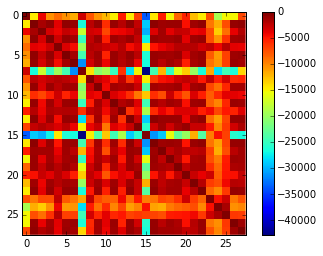

In [31]:
plt.imshow((kde_overlap+kde_overlap.T),interpolation='none');
plt.colorbar()